In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

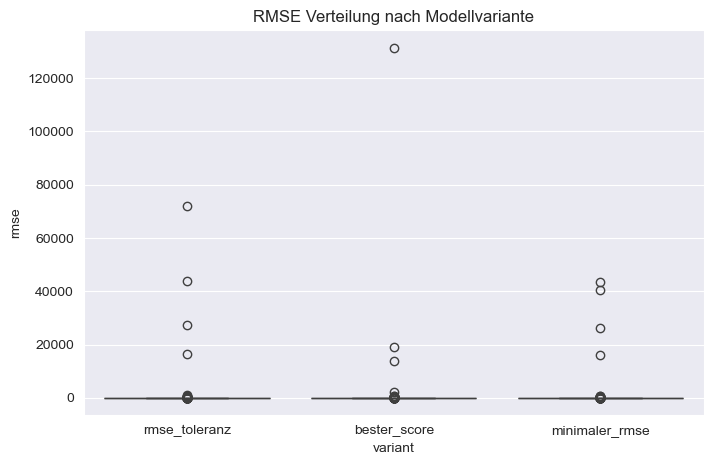

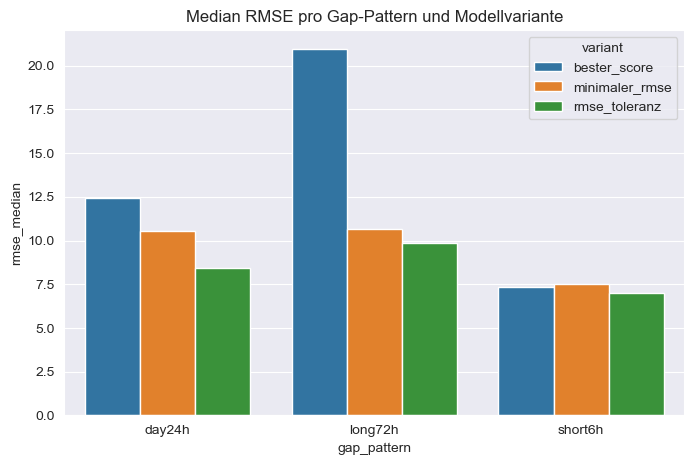

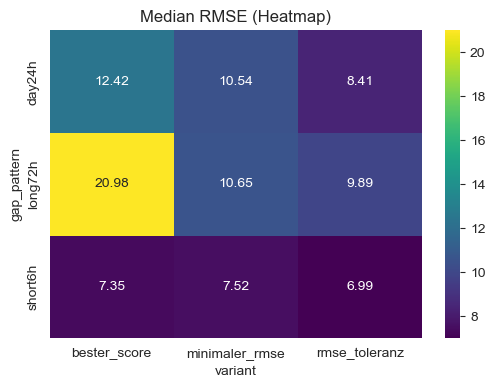

In [29]:
df = pd.read_csv("../data/experiment_results/experiment_summary.csv")

# Boxplot: RMSE nach Modellvariante
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="variant", y="rmse")
plt.title("RMSE Verteilung nach Modellvariante")
plt.show()

# Grouped Barplot: median RMSE pro Gap-Pattern + Modell
pivot = (
    df.groupby(["gap_pattern","variant"])
      .agg(rmse_median=("rmse","median"))
      .reset_index()
)
plt.figure(figsize=(8,5))
sns.barplot(data=pivot, x="gap_pattern", y="rmse_median", hue="variant")
plt.title("Median RMSE pro Gap-Pattern und Modellvariante")
plt.show()

# Heatmap
heat = pivot.pivot(index="gap_pattern", columns="variant", values="rmse_median")
plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="viridis")
plt.title("Median RMSE (Heatmap)")
plt.show()

In [8]:
import pickle
with open("../data/series_by_bin.pkl", "rb") as f:
    series_by_bin_loaded = pickle.load(f)

<Axes: xlabel='von'>

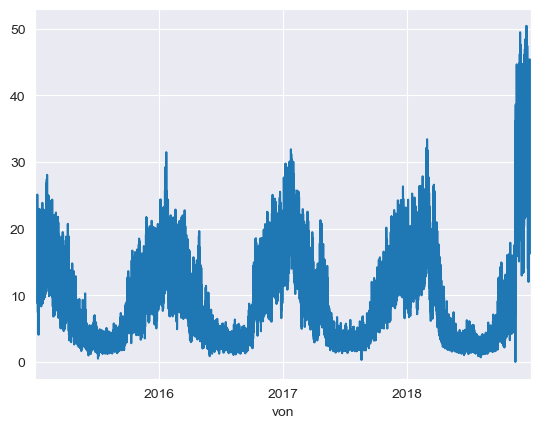

In [16]:
series_by_bin_loaded['0–5%']['FL_00024667.PLAN.MengeHH'].consumption.plot()

In [11]:
series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2'].isna().sum()

consumption    4
w_tl           0
w_rf           0
w_ff           0
w_ffx          0
w_cglo         0
w_so_h         0
w_rr           0
w_rrm          0
w_tb10         0
w_tb20         0
CEGH_WAP       0
THE_WAP        0
dtype: int64

In [12]:
series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2'][series_by_bin_loaded['0–5%']['FL_00024360.PLAN.MengeHH.2'].isna().any(axis=1)]

,consumption,w_tl,w_rf,w_ff,w_ffx,w_cglo,w_so_h,w_rr,w_rrm,w_tb10,w_tb20,CEGH_WAP,THE_WAP
von,,,,,,,,,,,,,
2015-03-29 02:00:00,NaN,1.5,82,0.8,1.8,0.0,0.0,0.0,0,6.2,6.9,22.68,22.32
2016-03-27 02:00:00,NaN,2.3,91,0.6,1.7,0.0,0.0,0.0,0,6.4,6.8,12.63,12.13
2017-03-26 02:00:00,NaN,6.4,64,2.9,6.1,0.0,0.0,0.0,0,7.7,7.7,16.19,15.53
2018-03-25 02:00:00,NaN,0.4,85,3.5,6.7,0.0,0.0,0.0,0,3.6,3.4,19.14,19.64


In [13]:
series_by_bin_loaded['0–5%'].keys()

dict_keys(['FL_00024360.PLAN.MengeHH.2', 'FL_00024360.PLAN.MengeGA', 'FL_00352244.PLAN.MengeKW', 'FL_00352244.PLAN.MengeGA', 'FL_00352251.PLAN.MengeGA', 'FL_00352254.PLAN.MengeGA', 'FL_00342704.PLAN.MengeGA', 'FL_00025248.PLAN.MengeGA', 'FL_00352208.PLAN.MengeGA', 'FL_00352054.PLAN.MengeHH', 'CV_00348266.PLAN.Menge', 'FL_00025240.PLAN.MengeHH', 'FL_00025241.PLAN.MengeHH', 'FL_00352218.PLAN.MengeHH', 'FL_00024667.PLAN.MengeHH', 'FL_00352255.PLAN.MengeHH', 'FL_00024673.PLAN.MengeHH', 'FL_00020896.PLAN.MengeHH', 'FL_00024679.PLAN.MengeHH', 'FL_00024741.PLAN.MengeHH', 'FL_00024731.PLAN.MengeHH', 'FL_00024735.PLAN.MengeHH', 'FL_00024730.PLAN.MengeHH', 'FL_00024745.PLAN.MengeHH', 'FL_00352243.PLAN.MengeHH', 'FL_00024702.PLAN.MengeHH', 'FL_00024725.PLAN.MengeHH', 'FL_00024728.PLAN.MengeHH', 'FL_00024727.PLAN.MengeHH', 'FL_00352244.PLAN.MengeHH', 'FL_00352254.PLAN.MengeHH', 'FL_00342704.PLAN.MengeHH', 'FL_00352208.PLAN.MengeHH', 'FL_00352430.PLAN.MengeHH', 'FL_00352191.PLAN.MengeHH', 'FL_00352

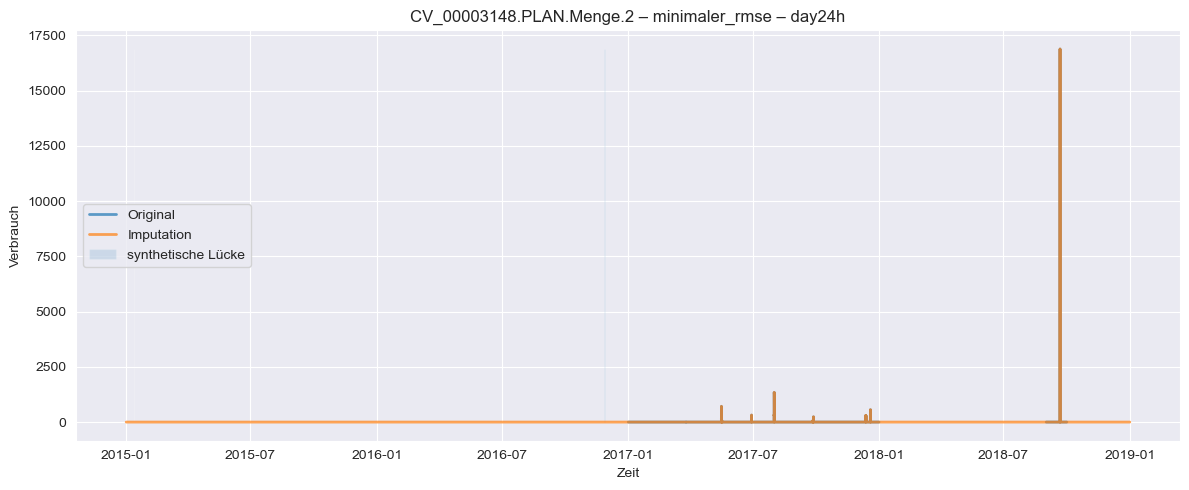

In [28]:
import numpy as np

def _safe(s: str) -> str:
    """Datei-/Ordner-sichere Namen (ersetzt problematische Zeichen)."""
    return (
        str(s)
        .replace("/", "_")
        .replace("\\", "_")
        .replace(":", "_")
        .replace("*", "_")
        .replace("?", "_")
        .replace('"', "_")
        .replace("<", "_")
        .replace(">", "_")
        .replace("|", "_")
    )

def plot_imputation(series_key: str,
                    variant: str,
                    bin_key: str,
                    gap_pattern: str,
                    base_dir: Path = "../data/experiment_results/imputed_series"):

    # exakt wie beim Speichern bereinigen
    v   = _safe(variant)
    b   = _safe(bin_key)
    sk  = _safe(series_key)
    gp  = _safe(gap_pattern)

    fn = Path(base_dir) / v / b / f"{sk}__{gp}.parquet"
    if not fn.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {fn}")

    df = pd.read_parquet(fn)

    # Spaltennamen aus dem Save-Block verwenden
    y_true = df["y_true"]
    y_imp  = df["y_imputed"]
    mask   = df["gap_mask"].astype(bool)

    plt.figure(figsize=(12,5))
    plt.plot(df.index, y_true, label="Original", alpha=0.7, lw=2)
    plt.plot(df.index, y_imp,  label="Imputation", alpha=0.7, lw=2)

    if mask.any():
        ymin = np.nanmin(np.c_[y_true.values, y_imp.values])
        ymax = np.nanmax(np.c_[y_true.values, y_imp.values])
        plt.fill_between(df.index, ymin, ymax, where=mask, alpha=0.15, label="synthetische Lücke")

    plt.title(f"{series_key} – {variant} – {gap_pattern}")
    plt.xlabel("Zeit"); plt.ylabel("Verbrauch"); plt.legend(); plt.tight_layout(); plt.show()


# Beispielaufruf:
plot_imputation(
    series_key="CV_00003148.PLAN.Menge.2",
    variant="minimaler_rmse",
    bin_key="_30%",
    gap_pattern="day24h"
)

Varianten: ['bester_score', 'minimaler_rmse', 'rmse_toleranz']
Gap-Patterns: ['day24h', 'long72h', 'short6h']
Bins: ['0–5%', '10–15%', '20–25%', '25–30%', '5–10%', '>30%']


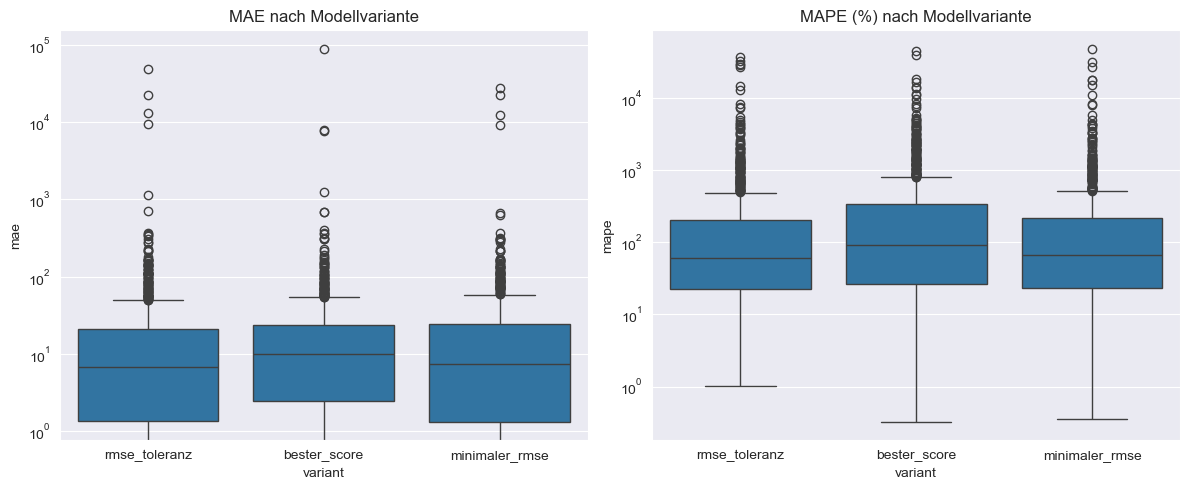

In [34]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/experiment_results/experiment_summary.csv")

# Sanity: welche Varianten/Pattern sind überhaupt drin?
print("Varianten:", sorted(df["variant"].dropna().unique()))
print("Gap-Patterns:", sorted(df["gap_pattern"].dropna().unique()))
print("Bins:", sorted(df["bin"].dropna().unique()))

# Basic: MAE/MAPE ebenfalls visualisieren
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(data=df, x="variant", y="mae", ax=axes[0])
axes[0].set_yscale("log")
#sns.boxplot(data=df, x="variant", y="mae", ax=axes[0])
axes[0].set_title("MAE nach Modellvariante")
sns.boxplot(data=df, x="variant", y="mape", ax=axes[1])
axes[1].set_yscale("log")
#sns.boxplot(data=df, x="variant", y="mape", ax=axes[1])
axes[1].set_title("MAPE (%) nach Modellvariante")
plt.tight_layout(); plt.show()

Text(0.5, 1.0, 'MAPE (%) nach Modellvariante')

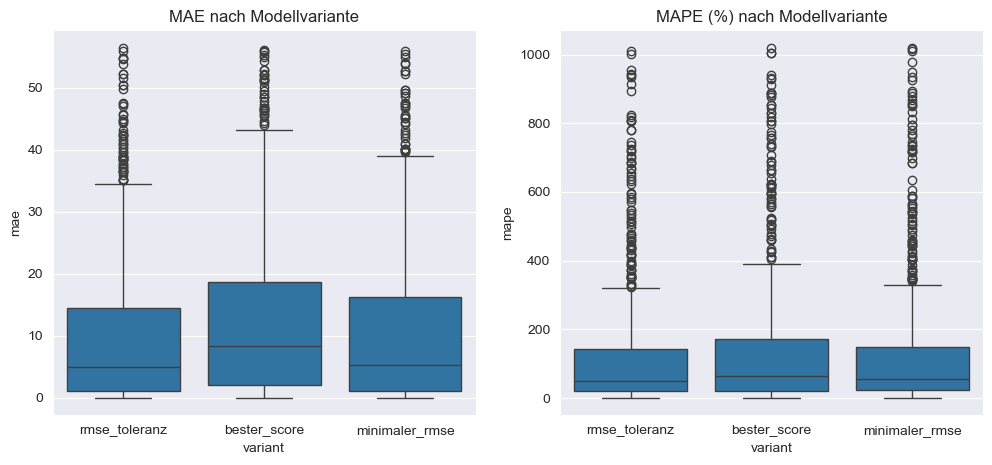

In [37]:
# Basic: MAE/MAPE ebenfalls visualisieren
q_mae = df["mae"].quantile(0.90)
q_mape = df["mape"].quantile(0.90)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(data=df[df["mae"] <= q_mae], x="variant", y="mae", ax=axes[0])
axes[0].set_title("MAE nach Modellvariante")
sns.boxplot(data=df[df["mape"] <= q_mape], x="variant", y="mape", ax=axes[1])
axes[1].set_title("MAPE (%) nach Modellvariante")

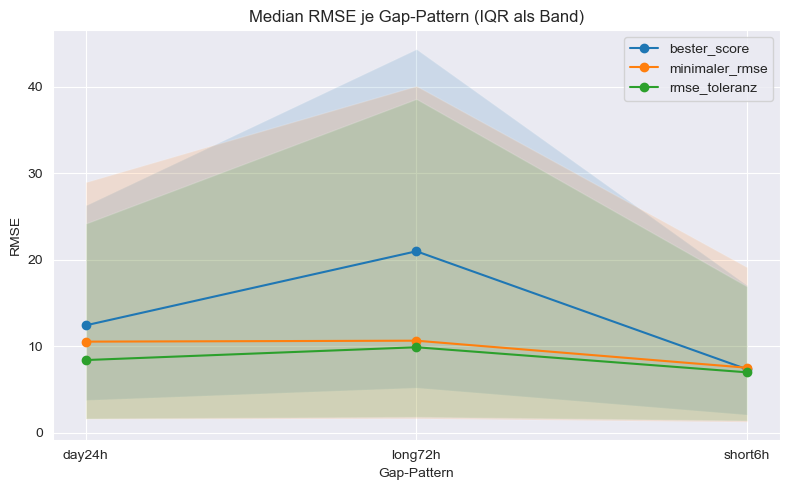

In [31]:
pivot_ci = (
    df.groupby(["gap_pattern","variant"])
      .agg(rmse_median=("rmse","median"),
           rmse_q25=("rmse", lambda x: np.nanpercentile(x, 25)),
           rmse_q75=("rmse", lambda x: np.nanpercentile(x, 75)),
           n=("rmse", "size"))
      .reset_index()
)

plt.figure(figsize=(8,5))
for v, sub in pivot_ci.groupby("variant"):
    x = sub["gap_pattern"]
    y = sub["rmse_median"]
    y1, y2 = sub["rmse_q25"], sub["rmse_q75"]
    plt.plot(x, y, marker="o", label=v)
    plt.fill_between(x, y1, y2, alpha=0.15)
plt.title("Median RMSE je Gap-Pattern (IQR als Band)")
plt.xlabel("Gap-Pattern"); plt.ylabel("RMSE"); plt.legend(); plt.tight_layout(); plt.show()

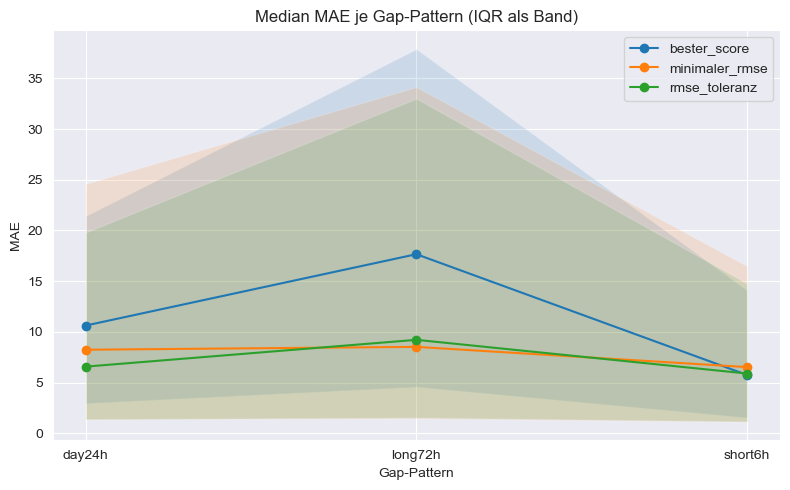

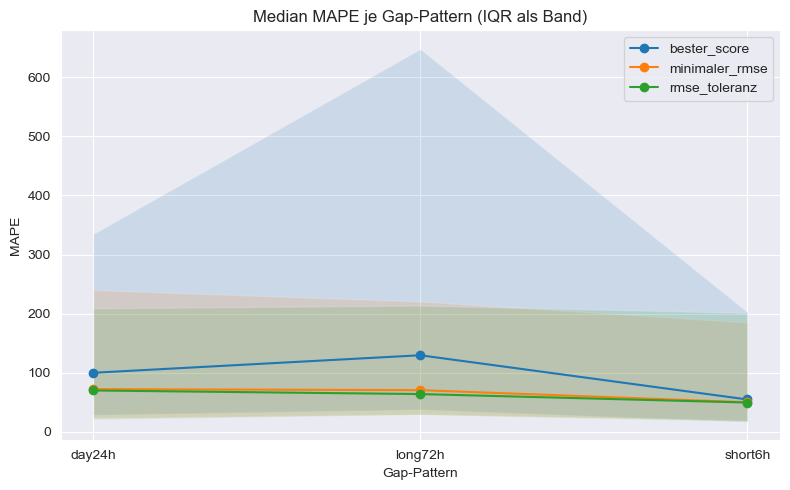

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_band(df, metric="mae", title=None):
    pivot_ci = (
        df.groupby(["gap_pattern","variant"])
          .agg(median=(metric,"median"),
               q25=(metric, lambda x: np.nanpercentile(x,25)),
               q75=(metric, lambda x: np.nanpercentile(x,75)))
          .reset_index()
    )

    plt.figure(figsize=(8,5))
    for v, sub in pivot_ci.groupby("variant"):
        x = sub["gap_pattern"]
        y = sub["median"]
        y1, y2 = sub["q25"], sub["q75"]
        plt.plot(x, y, marker="o", label=v)
        plt.fill_between(x, y1, y2, alpha=0.15)

    plt.title(title or f"Median {metric.upper()} je Gap-Pattern (IQR als Band)")
    plt.xlabel("Gap-Pattern")
    plt.ylabel(metric.upper())
    plt.legend()
    plt.tight_layout()
    plt.show()

# Aufruf für beide Metriken
plot_metric_band(df, metric="mae",  title="Median MAE je Gap-Pattern (IQR als Band)")
plot_metric_band(df, metric="mape", title="Median MAPE je Gap-Pattern (IQR als Band)")

In [39]:
# global pro Gap-Pattern
winners_global = (
    df.groupby(["gap_pattern","variant"])["rmse"]
      .median().reset_index()
      .sort_values(["gap_pattern","rmse"])
      .groupby("gap_pattern").first()
)
print("Gewinner je Gap-Pattern (global, nach Median-RMSE):")
print(winners_global)

# pro Bin + Gap-Pattern
winners_bin = (
    df.groupby(["bin","gap_pattern","variant"])["rmse"].median().reset_index()
      .sort_values(["bin","gap_pattern","rmse"])
      .groupby(["bin","gap_pattern"]).first()
)
print("\nGewinner je Bin & Gap-Pattern:")
print(winners_bin)

Gewinner je Gap-Pattern (global, nach Median-RMSE):
                   variant      rmse
gap_pattern                         
day24h       rmse_toleranz  8.409555
long72h      rmse_toleranz  9.888043
short6h      rmse_toleranz  6.992109

Gewinner je Bin & Gap-Pattern:
                           variant       rmse
bin    gap_pattern                           
0–5%   day24h        rmse_toleranz  13.182817
       long72h       rmse_toleranz  18.293678
       short6h       rmse_toleranz  10.707766
10–15% day24h       minimaler_rmse   4.214824
       long72h       rmse_toleranz   4.183072
       short6h      minimaler_rmse   3.856812
20–25% day24h        rmse_toleranz  11.796226
       long72h      minimaler_rmse   5.603412
       short6h        bester_score   5.930578
25–30% day24h         bester_score   0.108120
       long72h        bester_score   0.000000
       short6h        bester_score   0.000000
5–10%  day24h         bester_score  10.543167
       long72h        bester_score  17.27

In [40]:
from scipy.stats import friedmanchisquare
import itertools

def by_key_ranktest(frame, key_cols=("gap_pattern",), metric="rmse"):
    out = []
    for key, sub in frame.groupby(list(key_cols)):
        pivot = sub.pivot_table(index="series_key", columns="variant", values=metric, aggfunc="median")
        pivot = pivot.dropna(how="any")  # nur Serien mit allen Varianten
        if pivot.shape[0] < 5 or pivot.shape[1] < 2:
            continue
        stat, p = friedmanchisquare(*[pivot[c].values for c in pivot.columns])
        out.append({"key": key, "n_series": pivot.shape[0], "k_variants": pivot.shape[1], "stat": stat, "p": p})
    return pd.DataFrame(out)

print("\nFriedman-Tests pro Gap-Pattern:")
print(by_key_ranktest(df, key_cols=("gap_pattern",)))


Friedman-Tests pro Gap-Pattern:
          key  n_series  k_variants       stat             p
0   (day24h,)       295           3  44.240602  2.473292e-10
1  (long72h,)       263           3  77.823529  1.261349e-17
2  (short6h,)       301           3   6.073801  4.798339e-02


In [41]:
worst = df.sort_values("rmse", ascending=False).head(20)
print(worst[["series_key","bin","gap_pattern","variant","rmse","mae","mape","n_eval_points"]])

                    series_key     bin gap_pattern         variant  \
1938    CV_00005833.PLAN.Menge   5–10%     short6h    bester_score   
1935    CV_00005833.PLAN.Menge   5–10%     short6h   rmse_toleranz   
9     FL_00024360.PLAN.MengeGA    0–5%     short6h   rmse_toleranz   
15    FL_00024360.PLAN.MengeGA    0–5%     short6h  minimaler_rmse   
1941    CV_00005833.PLAN.Menge   5–10%     short6h  minimaler_rmse   
2268    CV_00003155.PLAN.Menge  20–25%     short6h   rmse_toleranz   
2274    CV_00003155.PLAN.Menge  20–25%     short6h  minimaler_rmse   
2271    CV_00003155.PLAN.Menge  20–25%     short6h    bester_score   
1746  FL_00352230.PLAN.MengeGA   5–10%     short6h   rmse_toleranz   
1752  FL_00352230.PLAN.MengeGA   5–10%     short6h  minimaler_rmse   
12    FL_00024360.PLAN.MengeGA    0–5%     short6h    bester_score   
1749  FL_00352230.PLAN.MengeGA   5–10%     short6h    bester_score   
578   FL_00024360.PLAN.MengeKW  10–15%     long72h   rmse_toleranz   
577   FL_00024360.PL

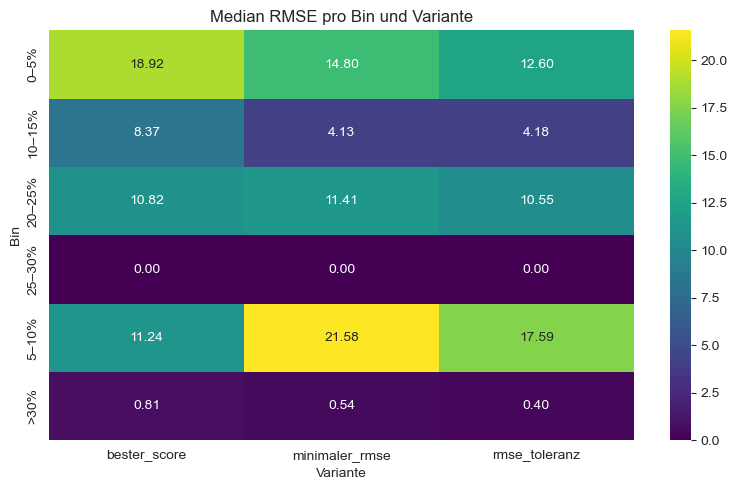

In [42]:
heat_bin = (
    df.groupby(["bin","variant"])["rmse"].median().reset_index()
      .pivot(index="bin", columns="variant", values="rmse")
)
plt.figure(figsize=(8,5))
sns.heatmap(heat_bin, annot=True, fmt=".2f", cmap="viridis")
plt.title("Median RMSE pro Bin und Variante")
plt.ylabel("Bin"); plt.xlabel("Variante"); plt.tight_layout(); plt.show()

In [43]:
skips = pd.read_csv("../data/experiment_results/debug_skips.csv")
print("Skip-Statistik (Top 10):")
print(skips["stage"].value_counts().head(10))
print("\nHäufigste Gründe je Stage:")
print(skips.groupby("stage")["reason"].agg(lambda s: s.value_counts().head(3)).to_string())

EmptyDataError: No columns to parse from file

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def _contiguous_true_spans(mask: pd.Series) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """Finde zusammenhängende True-Segmente im bool-Indexmask."""
    m = mask.astype(int).values
    if m.sum() == 0:
        return []
    # Kanten finden
    dm = np.diff(np.r_[0, m, 0])
    starts = np.where(dm == 1)[0]
    ends   = np.where(dm == -1)[0]  # end-idx ist exklusiv
    idx = mask.index
    spans = []
    for s, e in zip(starts, ends):
        spans.append((idx[s], idx[e-1]))  # inklusives Ende
    return spans

def plot_imputation_zoomed(
    series_key: str,
    variant: str,
    bin_key: str,
    gap_pattern: str,
    base_dir: Path = Path("../data/experiment_results/imputed_series"),
    pad_hours: int = 48,          # Kontext links/rechts des Gaps
    max_zoom_panels: int = 6,     # nicht unendlich viele Subplots
    show_overview: bool = True,   # Gesamtübersicht oben
):
    # ---- Datei laden (wie bei dir) ----
    def _safe(s: str) -> str:
        return (str(s).replace("/", "_").replace("\\", "_").replace(":", "_")
                .replace("*", "_").replace("?", "_").replace('"', "_")
                .replace("<", "_").replace(">", "_").replace("|", "_"))

    v  = _safe(variant)
    b  = _safe(bin_key)
    sk = _safe(series_key)
    gp = _safe(gap_pattern)
    fn = Path(base_dir) / v / b / f"{sk}__{gp}.parquet"
    if not fn.exists():
        raise FileNotFoundError(f"Datei nicht gefunden: {fn}")

    df = pd.read_parquet(fn)
    y_true = df["y_true"]
    y_imp  = df["y_imputed"]
    mask   = df["gap_mask"].astype(bool)

    # ---- Gap-Segmente bestimmen ----
    spans = _contiguous_true_spans(mask)
    if not spans:
        print("Keine True-Segmente im Gap-Mask gefunden.")
        # zur Not nur den Überblick plotten
        plt.figure(figsize=(12,4))
        plt.plot(df.index, y_true, label="Original", lw=1.5, alpha=0.8)
        plt.plot(df.index, y_imp,  label="Imputation", lw=1.5, alpha=0.8)
        plt.title(f"{series_key} – {variant} – {gap_pattern}")
        plt.legend(); plt.tight_layout(); plt.show()
        return

    n_zoom = min(len(spans), max_zoom_panels)
    n_rows = 1 + n_zoom if show_overview else n_zoom
    height = 3.0*n_rows + (2 if show_overview else 0)

    fig, axes = plt.subplots(n_rows, 1, figsize=(14, height), sharey=False)
    if n_rows == 1:
        axes = [axes]
    ax_idx = 0

    # ---- Übersicht (kompletter Zeitraum) ----
    if show_overview:
        ax = axes[ax_idx]; ax_idx += 1
        ax.plot(df.index, y_true, label="Original", lw=1.2, alpha=0.8)
        ax.plot(df.index, y_imp,  label="Imputation", lw=1.2, alpha=0.8)
        if mask.any():
            ymin = np.nanmin(np.c_[y_true.values, y_imp.values])
            ymax = np.nanmax(np.c_[y_true.values, y_imp.values])
            ax.fill_between(mask.index, ymin, ymax, where=mask.values, alpha=0.12, label="synthetische Lücke")
        ax.set_title(f"{series_key} – {variant} – {gap_pattern} (Übersicht)")
        ax.set_xlabel("Zeit"); ax.set_ylabel("Verbrauch")
        ax.legend(loc="upper left")

    # ---- Zoom-Panels je Gap ----
    for i, (start, end) in enumerate(spans[:n_zoom], start=1):
        ax = axes[ax_idx]; ax_idx += 1
        left  = start - pd.Timedelta(hours=pad_hours)
        right = end   + pd.Timedelta(hours=pad_hours)
        win = df.loc[(df.index >= left) & (df.index <= right)].copy()
        mwin = mask.loc[win.index]

        ax.plot(win.index, win["y_true"], label="Original", lw=1.8, alpha=0.85)
        ax.plot(win.index, win["y_imputed"], label="Imputation", lw=1.8, alpha=0.85)

        if mwin.any():
            ymin = np.nanmin(np.c_[win["y_true"].values, win["y_imputed"].values])
            ymax = np.nanmax(np.c_[win["y_true"].values, win["y_imputed"].values])
            ax.fill_between(win.index, ymin, ymax, where=mwin.values, alpha=0.18, label="synthetische Lücke")

        # kleine Metriken nur im Gap (optional)
        eval_mask = mwin & win["y_true"].notna()
        if eval_mask.any():
            e = (win["y_true"][eval_mask] - win["y_imputed"][eval_mask]).values
            rmse = float(np.sqrt(np.mean(np.square(e))))
            mae  = float(np.mean(np.abs(e)))
            ax.set_title(f"Gap {i}: {start:%Y-%m-%d %H:%M} → {end:%Y-%m-%d %H:%M}  |  RMSE={rmse:.2f}, MAE={mae:.2f}")
        else:
            ax.set_title(f"Gap {i}: {start:%Y-%m-%d %H:%M} → {end:%Y-%m-%d %H:%M}")

        ax.set_xlim(left, right)
        ax.set_xlabel("Zeit"); ax.set_ylabel("Verbrauch")

    plt.tight_layout()
    plt.show()